# What questions do we want to investigate here?

1. Which tracks have the most/least consensus among annotators?
2. Which annotators have the most/least consensus among each other?

Each of the above can be approached with each metric.  What do we want to show with l-measures?

- That disagreement in L-measure implies disagreement in other metrics
- That agreement in L-measure does not necessarily imply agreement elsewhere
    - ie, L-measure is robust to variation in annotation level that the others are not
    
- Scatter plot flat metric vs L-measure, break into quadrants
    - should be triangular

In [1]:
import pandas as pd
import os
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

%matplotlib nbagg

In [2]:
import jams
import json

In [3]:
from mir_eval.util import f_measure

In [4]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool

In [5]:
from bokeh.io import output_notebook
output_notebook()

def bscat(df, xkey, ykey, **kwargs):
    
    fig = bp.figure(tools=[BoxSelectTool(), 
                           HoverTool(tooltips=[("desc", "@desc")])],
                    x_axis_label=xkey,
                    y_axis_label=ykey,
                    **kwargs)
    
    df = df.dropna()
    
    source = bp.ColumnDataSource(data=dict(x=df[xkey].values,
                                           y=df[ykey].values,
                                           desc=df['TRACK'].values))
    
    fig.scatter('x', 'y', source=source)
    return fig

Loading BokehJS ...

In [142]:
SALAMI = True

if SALAMI:
    results = pickle.load(open('../data/salami_all_results.pickle', 'rb'))
    SETNAME = 'SALAMI'
else:
    results = pickle.load(open('../data/spam_all_results.pickle', 'rb'))
    SETNAME = 'SPAM'

for k in results:
    seen_pairs = set()
    for u1 in list(results[k].keys()):
        for u2 in list(results[k][u1].keys()):
            new_set = frozenset([u1, u2])
            if new_set in seen_pairs:
                results[k][u1].pop(u2)
            seen_pairs.add(new_set)

for k in results:
    for u1 in results[k]:
        for u2 in results[k][u1]:
            results[k][u1][u2]['TRACK'] = k

results_tab = []
for track in results:
    for a1 in results[track]:
        for a2 in results[track][a1]:
            v = dict()
            v.update(results[track][a1][a2])
            v['annotator 1'] = a1
            v['annotator 2'] = a2
            results_tab.append(v)
R = pd.DataFrame.from_records(results_tab)

# Load in the feature agreements
if SALAMI:
    feature_data = json.load(open('../data/salami_feature_correlations.json', 'r'))
else:
    feature_data = json.load(open('../data/spam_feature_correlations.json', 'r'))
    
F = pd.DataFrame.from_dict(feature_data)
F = F.sort_values(by=['track', 'annotator'])

# Load in the NCE agreements
if SALAMI:
    nce_data = pd.DataFrame.from_csv('../data/salami_annotator_metrics.tsv', sep='\t')
else:
    nce_data = pd.DataFrame.from_csv('../data/spam_annotator_metrics.tsv', sep='\t')


nce_data['track'] = ['{}.jams'.format(_) for _ in nce_data.index]

# Boundary metrics

In [ ]:
df = R[['TRACK', 'UPPER_F-measure@0.5', 'LOWER_F-measure@0.5', 'MULTI_T-Measure reduced', 'MULTI_T-Measure full']]
df.columns = ['TRACK', 'F Upper', 'F Lower', 'T-measure reduced', 'T-Measure full']

In [ ]:
sns.jointplot(df['F Lower'], df['F Upper'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_boundary_f_lower_f_upper.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'F Lower', 'F Upper', plot_width=400, plot_height=400))


In [ ]:
sns.jointplot(df['F Lower'], df['F Upper'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_boundary_f_lower_f_upper.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'F Lower', 'F Upper', plot_width=400, plot_height=400))


In [ ]:
sns.jointplot(df['F Lower'], df['T-Measure reduced'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_boundary_f_lower_t_reduced.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'F Lower', 'T-Measure reduced', plot_width=400, plot_height=400))

In [ ]:
sns.jointplot(df['F Upper'], df['T-Measure reduced'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_boundary_f_upper_t_reduced.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'F Upper', 'T-Measure reduced', plot_width=400, plot_height=400))

In [ ]:
sns.jointplot(df['F Lower'], df['T-Measure full'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_boundary_f_lower_t_full.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'F Lower', 'T-Measure full', plot_width=400, plot_height=400))

In [ ]:
sns.jointplot(df['F Upper'], df['T-Measure full'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_boundary_f_upper_t_full.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'F Upper', 'T-Measure full', plot_width=400, plot_height=400))

---
# Labeled segmentation metrics

In [640]:
df = R[['TRACK',
        'UPPER_NCE F-measure', 'LOWER_NCE F-measure',
        'UPPER_Pairwise F-measure', 'LOWER_Pairwise F-measure',
        'MULTI_L-Measure']]
df.columns = ['TRACK',
              'UPPER_NCE F-measure', 'LOWER_NCE F-measure',
              'UPPER_Pairwise F-measure', 'LOWER_Pairwise F-measure',
              'L-Measure']              

In [641]:
df_mean = df.groupby(by='TRACK').mean()

df_mean.sort('L-Measure', inplace=True)

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [642]:
order = df_mean.index

In [643]:
df_std = (df.groupby(by='TRACK').max() - df.groupby(by='TRACK').min()).loc[order]

In [ ]:
# upper NCE:
# SPAM: 497 is the most improvement over upper-nce -- looks pretty consistent
# SPAM: 492 third most over upper nce
# SPAM: 353 -- lowest over upper-nce -- looks totally different

# lower nce
# 175 is lowest
#R.loc[175][['TRACK', 'annotator 1', 'annotator 2']].values

<IPython.core.display.Javascript object>


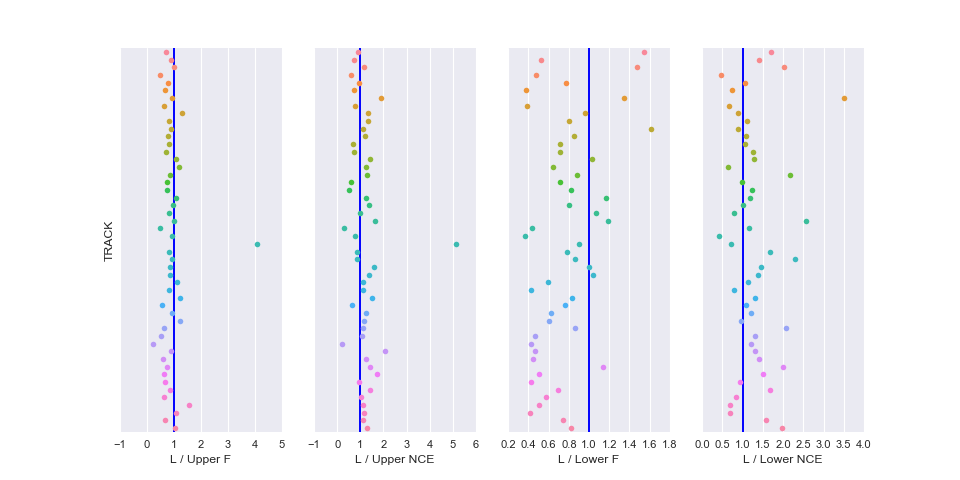

In [644]:
plt.figure(figsize=(12, 6))

plt.subplot(1,4,1)
sns.stripplot(df_std['L-Measure'] / (df_std['UPPER_Pairwise F-measure']), df_std.index, order=order, orient='h')
plt.axvline(1)
plt.yticks([])
plt.xlabel('L / Upper F')

plt.subplot(1,4,3)
sns.stripplot(df_std['L-Measure'] / (df_std['LOWER_Pairwise F-measure']), df_std.index, order=order, orient='h')
plt.axvline(1)
plt.xlabel('L / Lower F')
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,2)
sns.stripplot(df_std['L-Measure'] / (df_std['UPPER_NCE F-measure']), df_std.index, order=order, orient='h')
plt.axvline(1)
plt.xlabel('L / Upper NCE')
plt.gca().yaxis.set_visible(False)

plt.subplot(1,4,4)
sns.stripplot(df_std['L-Measure'] / (df_std['LOWER_NCE F-measure']), df_std.index, order=order, orient='h')
plt.axvline(1)
plt.xlabel('L / Lower NCE')
plt.gca().yaxis.set_visible(False)

In [ ]:
df_max = pd.DataFrame()
df_max['TRACK'] = R['TRACK']
df_max['Max F-measure'] = R[['UPPER_Pairwise F-measure', 'LOWER_Pairwise F-measure']].max(axis=1)
df_max['Max NCE'] = R[['UPPER_NCE F-measure', 'LOWER_NCE F-measure']].max(axis=1)
df_max['Min F-measure'] = R[['UPPER_Pairwise F-measure', 'LOWER_Pairwise F-measure']].min(axis=1)
df_max['Min NCE'] = R[['UPPER_NCE F-measure', 'LOWER_NCE F-measure']].min(axis=1)
df_max['L-measure'] = R['MULTI_L-Measure']

In [ ]:
def quadrant(x, y, **kwargs):
    
    text_kwargs = kwargs.pop('text_kwargs', dict())
    
    ax = plt.gca()
    
    plt.axvline(np.nanmedian(x), **kwargs)
    plt.axhline(np.nanmedian(y), **kwargs)
    
    plt.text(0.98, 0.98, 'I',
             horizontalalignment='right',
             verticalalignment='top',
             transform = ax.transAxes,
             **text_kwargs
            )
    plt.text(0.02, 0.98, 'II',
             horizontalalignment='left',
             verticalalignment='top',
             transform = ax.transAxes,
             **text_kwargs)
    
    plt.text(0.02, 0.02, 'III',
             horizontalalignment='left',
             verticalalignment='bottom',
             transform = ax.transAxes,
            **text_kwargs)
    
    plt.text(0.98, 0.02, 'IV',
             horizontalalignment='right',
             verticalalignment='bottom',
             transform = ax.transAxes,
            **text_kwargs)

In [ ]:
import matplotlib.style as ms

In [ ]:
ms.available

In [ ]:
ms.use('seaborn-deep')

In [ ]:
sns.set()

In [ ]:
import matplotlib.colors as mc

In [ ]:
sns.color_palette()

In [ ]:
sblue = mc.colorConverter.to_rgb(sns.color_palette()[0])
sred = mc.colorConverter.to_rgb(sns.color_palette()[3])

In [ ]:
def quadmarg(x, y):
    
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    xmed = np.median(x)
    ymed = np.median(y)
    
    n = float(len(x))
    
    q1 = sum((x >= xmed) & (y >= ymed))
    q2 = sum((x < xmed) & (y >= ymed))
    q3 = sum((x < xmed) & (y < ymed))
    q4 = sum((x >= xmed) & (y < ymed))
    
    return q1/n, q2/n, q3/n, q4/n

In [ ]:
q1, q2, q3, q4 = quadmarg(df_max['Max F-measure'], df_max['L-measure'])
print('Max: q3/(q2+q3) = {:.3f}'.format(q3/(q2+q3)))

In [ ]:
q2

In [ ]:
q1, q2, q3, q4 = quadmarg(df_max['Min F-measure'], df_max['L-measure'])
print('Min: q1/(q1+q4) = {:.3f}'.format(q1/(q1+q4)))

In [ ]:
q4

In [ ]:
plt.figure(figsize=(8, 4))

ax1 = plt.subplot(1,2,1)

plt.scatter(df_max['Max F-measure'], df_max['L-measure'], alpha=0.5, color=sblue)

quadrant(df_max['Max F-measure'], df_max['L-measure'], alpha=0.5, color='r',
         text_kwargs=dict(fontdict=dict(family='serif')))
plt.xlabel('Max F-measure')
plt.ylabel('L-measure')
plt.xlim([0, 1.1])
plt.ylim([0, 1])

ax2 = plt.subplot(1,2,2, sharey=ax1)

plt.scatter(df_max['Min F-measure'], df_max['L-measure'], alpha=0.5, color=sblue)
quadrant(df_max['Min F-measure'], df_max['L-measure'], alpha=0.5, color='r',
         text_kwargs=dict(fontdict=dict(family='serif')))
plt.xlabel('Min F-measure')

plt.xlim([0, 1.1])
plt.ylim([0, 1])

plt.tight_layout()
plt.savefig('../data/figures/{}_cross_level_lmeasure.pdf'.format(SETNAME), pad_inches=0)

In [ ]:
g = sns.PairGrid(df_max, vars=['Max F-measure', 'Min F-measure', 'L-measure'])

g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, alpha=0.5)
g.map_offdiag(quadrant, alpha=0.5, color='r', text_kwargs=dict(fontdict=dict(family='serif')))

#plt.savefig('../data/figures/{}_cross_level_lmeasure.pdf'.format(SETNAME), pad_inches=0)

### SALAMI outliers
```
- (I)   555 high max F-measure, high L-measure ==? legit agreement
- (II)  347 low max F-measure, high L-measure  ==> spurious low flat score
- (III) 436 low max F-measure, low L-measure   ==> legit disagreement
- (IV)  616 high max F-measure, low L-measure  ==? match on one level but not the other

- (I)   829 high min F-measure, high L-measure ==> legit agreement
- (II)  307 low min F-measure, high L-measure  ==? match one level but not the other
- (III) 768 low min F-measure, low L-measure   ==? legit disagreement
- (IV) 1342 high min F-measure, low L-measure ==> strange??? CHECK THIS


```

In [ ]:
R[R.TRACK == '1342.jams'][['MULTI_L-Measure', 'UPPER_Pairwise F-measure', 'LOWER_Pairwise F-measure']]

In [ ]:
bp.show(bscat(df_max, 'Min F-measure', 'L-measure', plot_width=400, plot_height=400))

In [ ]:
bp.show(bscat(df_max, 'Max F-measure', 'L-measure', plot_width=400, plot_height=400))

In [ ]:
fig = plt.figure(figsize=(12, 6))

plt.subplot(1,5,5)
sns.stripplot(df['L-Measure'], df['TRACK'], order=order, orient='h')
plt.xlim([0, 1])

plt.gca().yaxis.set_visible(False)

plt.subplot(1,5,3)
sns.stripplot(df['UPPER_Pairwise F-measure'], df['TRACK'], order=order, orient='h')
plt.xlabel('Upper pairwise')
plt.xlim([0, 1])
plt.gca().yaxis.set_visible(False)

plt.subplot(1,5,4)
sns.stripplot(df['LOWER_Pairwise F-measure'], df['TRACK'], order=order, orient='h')
plt.xlabel('Lower pairwise')
plt.xlim([0, 1])
plt.gca().yaxis.set_visible(False)

plt.subplot(1,5,1)
sns.stripplot(df['UPPER_NCE F-measure'], df['TRACK'], order=order, orient='h')
plt.xlabel('Upper NCE')
plt.xlim([0, 1])
plt.yticks([])
plt.ylabel('Track')

plt.subplot(1,5,2)
sns.stripplot(df['LOWER_NCE F-measure'], df['TRACK'], order=order, orient='h')
plt.xlabel('Lower NCE')
plt.xlim([0, 1])
plt.gca().yaxis.set_visible(False)

plt.suptitle('Distribution of pairwise inter-annotator agreements')

In [ ]:
df.loc[df['L-Measure'].argsort()]

In [ ]:
#fig.savefig('../data/figures/SPAM_agreement_distribution.pdf', pad_inches=0)

In [ ]:
sns.pairplot(df.dropna(), kind='reg', plot_kws=dict(order=1, n_boot=500, robust=True,
                                                    line_kws=dict(color='r'),
                                                    truncate=True,
                                                    scatter_kws=dict(alpha=0.5)))
plt.suptitle(SETNAME)
plt.tight_layout()
fig = plt.gcf()


In [ ]:
fig.savefig('../data/figures/{}_all_metrics.pdf'.format(SETNAME), pad_inches=0)

In [ ]:
sns.jointplot(df['LOWER_NCE F-measure'], df['UPPER_NCE F-measure'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
#plt.savefig('../data/figures/{}_label_nce_lower_nce_upper.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'LOWER_NCE F-measure', 'UPPER_NCE F-measure', plot_width=400, plot_height=400))

In [ ]:
sns.jointplot(df['LOWER_NCE F-measure'], df['L-Measure'], stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_label_nce_lower_l_measure.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'LOWER_NCE F-measure', 'MULTI_L-Measure', plot_width=400, plot_height=400))

In [ ]:
sns.jointplot(df['UPPER_NCE F-measure'],
              df['L-Measure'], kind='scatter', stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_label_nce_upper_l_measure.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'UPPER_NCE F-measure', 'MULTI_L-Measure', plot_width=400, plot_height=400))

In [ ]:
bp.show(bscat(df, 'LOWER_Pairwise F-measure', 'L-Measure', plot_width=600, plot_height=600))

In [ ]:
bp.show(bscat(df, 'UPPER_Pairwise F-measure', 'L-Measure', plot_width=600, plot_height=600))

In [ ]:
sns.jointplot(df['LOWER_Pairwise F-measure'],
              df['UPPER_Pairwise F-measure'], kind='scatter', stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_label_pairwise_lower_pairwise_upper.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'LOWER_Pairwise F-measure', 'UPPER_Pairwise F-measure', plot_width=400, plot_height=400))

In [ ]:
sns.jointplot(df['LOWER_Pairwise F-measure'],
              df['L-Measure'], kind='scatter', stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_label_pairwise_lower_l_measure.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'LOWER_Pairwise F-measure', 'MULTI_L-Measure', plot_width=400, plot_height=400))

In [ ]:
sns.jointplot(df['UPPER_Pairwise F-measure'],
              df['L-Measure'], kind='scatter', stat_func=None, xlim=[0, 1], ylim=[0, 1])
plt.savefig('../data/figures/{}_label_pairwise_upper_l_measure.pdf'.format(SETNAME), pad_inches=0)
#bp.show(bscat(df, 'UPPER_Pairwise F-measure', 'MULTI_L-Measure', plot_width=400, plot_height=400))

---
# Diagnostics

In [ ]:
df.sort(columns=['L-Measure']).tail(500).head(10)

In [7]:
import jams.display

In [ ]:
# high L, low F-low = 307
# high L, low F-upp = 994
# low L, high F-low = 12
# low L, high F-upp = 341, 374

In [ ]:
#idx = 341
#idx = 160
#idx = 936
#idx = 493

## max-vs-L plots
#idx = 555
#idx = 347
#idx = 436
#idx = 616

## min-vs-L plots
#idx = 829
#idx = 307
#idx = 768
idx = 1342

jam = jams.load('/home/bmcfee/git/segment_hierarchy_labels/data/SALAMI/{}.jams'.format(idx))
#idx = df['Track'][8]
#jam = jams.load('/home/bmcfee/git/msaf-data/SPAM/references/{}'.format(idx), validate=False)

In [ ]:
fig, axs = jams.display.display_multi(jam.annotations['multi_segment'], meta=False, fig_kw=dict(figsize=(6, 6)))

for ax in axs:
    ax.set_title('')
    
fig.suptitle('{} - {}'.format(SETNAME, idx), verticalalignment='center')
plt.tight_layout()
fig.savefig('../data/figures/multi_{}.pdf'.format(idx), pad_inches=0)

---
# Hierarchy information analysis

In [186]:
# Load the hierarchy NCE scores


# Join to R


# Scatter against L-measure

In [352]:
import numpy as np

In [353]:
nce_data['annotator_name'] = [str(_) for _ in nce_data['annotator_name']]

In [354]:
Rh = R.merge(nce_data,
        how='inner',
        left_on=['TRACK', 'annotator 1'],
        right_on=['track', 'annotator_name'], suffixes=('', '_1'))
Rh = Rh.merge(nce_data,
                how='inner',
                left_on=['TRACK', 'annotator 2'],
                right_on=['track', 'annotator_name'], suffixes=('', '_2'))

In [355]:
Rh['bad'] = (Rh['S_f'] >= 0.95) | (Rh['S_f_2'] >= 0.95)
#Rh['doublebad'] =(Rh['S_f'] >= 0.95) & (Rh['S_f_2'] >= 0.95)
#Rh['onebad'] = (Rh['S_f'] >= 0.95) ^ (Rh['S_f_2'] >= 0.95)

In [356]:
Rh['hier'] = np.add(Rh['S_f'].values, Rh['S_f_2'].values)

<IPython.core.display.Javascript object>


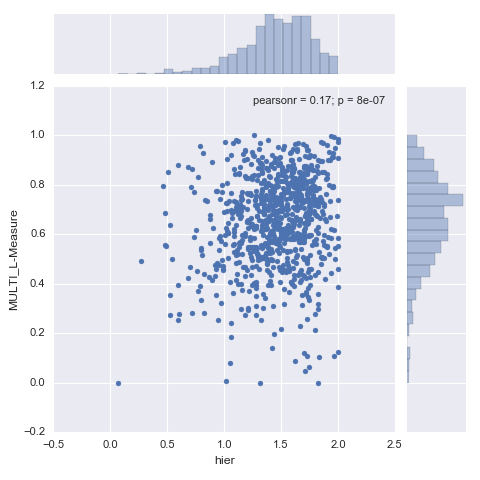

In [357]:
sns.jointplot(Rh['hier'], Rh['MULTI_L-Measure'])

---
# Feature correlation analysis


In [8]:
# Compute the feature disagreement scores


# Join to R


# scatter plot feature disagreement vs L-measure

In [9]:
import numpy as np

In [10]:
if SALAMI:
    transforms = np.load('../data/feature_basis_correlation_salami.npz')
else:
    transforms = np.load('../data/feature_basis_correlation_spam.npz')

In [11]:
tracks = set(R.TRACK)

In [12]:
F = F[F.track.isin(tracks)]

In [13]:
Fdiff = []
for track in F.track.unique():
    Ft = F[F.track == track]
    
    if SALAMI:
        Z = np.linalg.inv(transforms[os.extsep.join([os.path.splitext(track)[0], 'npz'])])
    else:
        Z = np.linalg.inv(transforms['SPAM_{}'.format(os.extsep.join([os.path.splitext(track)[0], 'mp3.npz']))])
        
    for a1 in Ft.annotator.unique():
        v1 = Ft[Ft.annotator == a1][['tempo', 'rhythm', 'chroma', 'mfcc']].values.squeeze()
        for a2 in Ft.annotator.unique():
            if a1 == a2:
                continue
            v2 = Ft[Ft.annotator == a2][['tempo', 'rhythm', 'chroma', 'mfcc']].values.squeeze()
            
            diff = v1 - v2
            delta = np.sqrt(diff.dot(diff))
            delta_w = np.sqrt(diff.dot(Z.dot(diff)))
            
            Fdiff.append({'annotator 1': a1, 'annotator 2': a2, 'delta':delta, 'delta_w': delta_w, 'TRACK': track})
            Fdiff.append({'annotator 1': a2, 'annotator 2': a1, 'delta':delta, 'delta_w': delta_w, 'TRACK': track})
Fdiff = pd.DataFrame.from_records(Fdiff)

In [14]:
if SALAMI:
    anonymap = {a: a for a in F.annotator.unique()}
else:
    anonymap = {a: '{:02d}'.format(i) for i, a in enumerate(sorted(F.annotator.unique()), 1)}
Fanon = F.copy()
Fanon['annotator'] = Fanon['annotator'].apply(lambda x: anonymap[x])

In [16]:
Rf = R.merge(Fdiff, on=['TRACK', 'annotator 1', 'annotator 2'], how='inner')
#Rf = Rh.merge(Fdiff, on=['TRACK', 'annotator 1', 'annotator 2'], how='inner')

In [17]:
Rf = Rf.drop_duplicates()

In [18]:
F.groupby('annotator').count()

,chroma,mfcc,rhythm,tempo,track
annotator,,,,,
Colin Hua,50,50,50,50,50
Eleni Vasilia Maltas,50,50,50,50,50
Evan S. Johnson,50,50,50,50,50
John Turner,50,50,50,50,50
Shuli Tang,50,50,50,50,50


In [19]:
Fgrp = Fanon.groupby('annotator').count()['track']
for k in list(anonymap.keys()):
    if Fgrp.loc[anonymap[k]] < 10:
        anonymap.pop(k)

In [20]:
df_avg_l = pd.DataFrame(R.groupby('TRACK').mean()['MULTI_L-Measure'])

In [21]:
df_with_avg = R.merge(df_avg_l.reset_index(), how='left', on='TRACK', suffixes=('', '_mean')).sort_values('MULTI_L-Measure_mean')

In [22]:
Fanon2 = Fanon.merge(df_avg_l.reset_index(), how='left', left_on='track', right_on='TRACK').sort_values('MULTI_L-Measure')

<IPython.core.display.Javascript object>


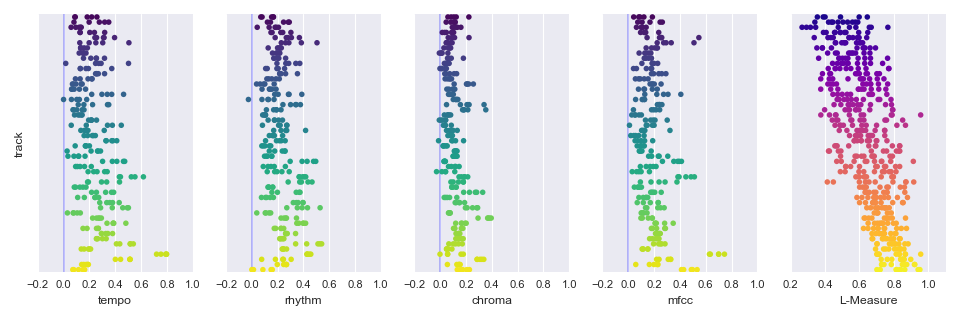

In [23]:
plt.figure(figsize=(12,4))
ax = None
for i, feature in enumerate(['tempo', 'rhythm', 'chroma', 'mfcc'], 1):
    
    ax = plt.subplot(1,5,i, sharex=ax, sharey=ax)
    plt.axvline(0, alpha=0.25)
    sns.stripplot(data=Fanon2, x=feature, y='track', palette='viridis')
    ax.set_yticklabels([])
    if i > 1:
        ax.set_ylabel('')
    
ax5 = plt.subplot(1,5,5, sharey=ax)
sns.stripplot(data=df_with_avg, x='MULTI_L-Measure', y='TRACK', palette='plasma')
ax5.set_yticklabels([])
ax5.set_xlabel('L-Measure')
ax5.set_ylabel('')

plt.tight_layout()

# What does this show?

- What if we look at variance of the feature-correlation scores against mean L-measure?
   - if the annotators all annotate similarly, then the featue correlations will have low variance
   - if not, feature correlations could have high variance?  or maybe they're just all small
-    

<IPython.core.display.Javascript object>


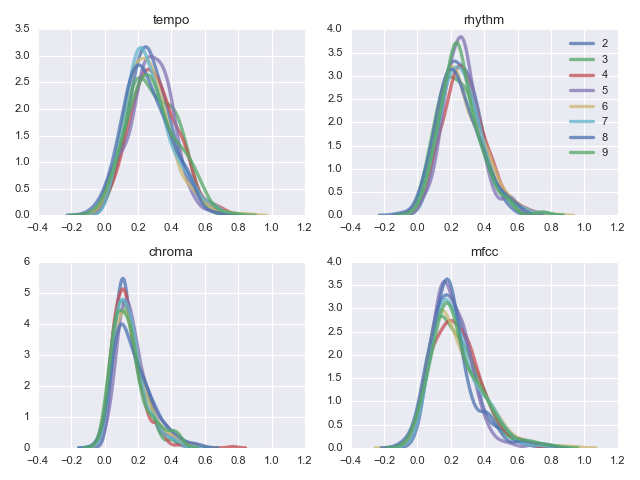

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [630]:
plt.figure()
ref_ax = None
for i, feature in enumerate(['tempo', 'rhythm', 'chroma', 'mfcc'], 1):
    ref_ax = plt.subplot(2,2,i, sharex=ref_ax)
    
    for an in sorted(anonymap.values()):    
        sns.kdeplot(Fanon[Fanon.annotator == an][feature], kernel='gau', label=an, alpha=0.75, linewidth=3)
        plt.title(feature)
    
    if i != 2:
        ref_ax.legend_.set_visible(False)
        
plt.tight_layout()

In [174]:
import scipy.stats

In [477]:
n_ann = len(anonymap)

Kd = dict()
Pd = dict()

if SALAMI:
    annos = [str(_) for _ in sorted([int(__) for __ in anonymap.values()])]
else:
    annos = sorted(anonymap.values())

for feature in ['tempo', 'rhythm', 'chroma', 'mfcc']:
    Kd[feature] = np.zeros((n_ann, n_ann))
    Pd[feature] = np.ones((n_ann, n_ann))
    for i, a1 in enumerate(annos, 1):
        for j, a2 in enumerate(annos, 1):
            if a1 == a2:
                continue
            Kd[feature][i-1, j-1], Pd[feature][i-1, j-1] = scipy.stats.ks_2samp(Fanon[Fanon.annotator == a1][feature],
                                               Fanon[Fanon.annotator == a2][feature])
            
Kt = dict()
for feature in Kd:
    Kt[feature] = pd.DataFrame(index=annos, columns=annos, data=Kd[feature])

In [478]:
# High KS statistic == large difference in the cdf == meaningful difference

In [479]:
Fgrp[Fgrp > 10]

annotator
01    50
02    50
03    50
04    50
05    50
Name: track, dtype: int64

In [480]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc

<IPython.core.display.Javascript object>


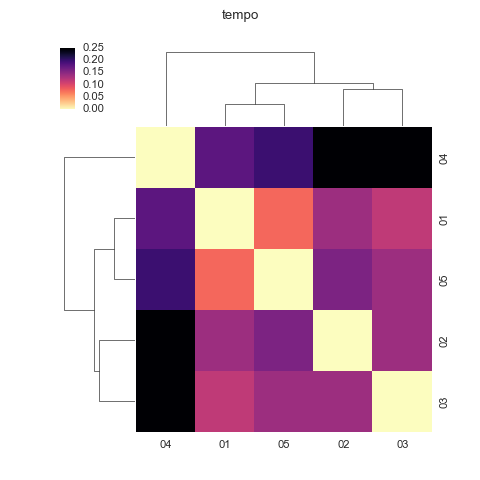

<IPython.core.display.Javascript object>


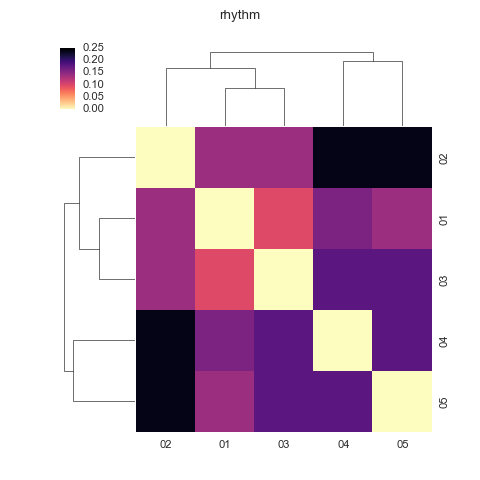

<IPython.core.display.Javascript object>


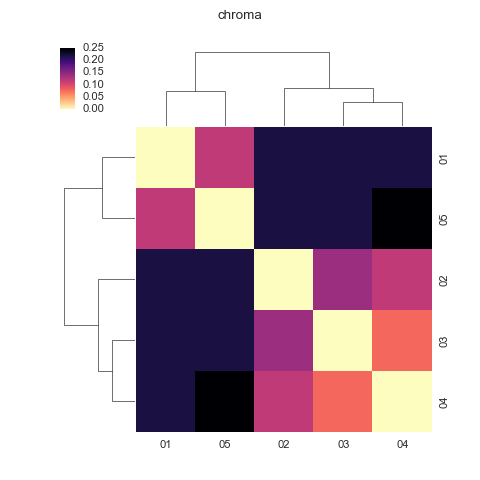

<IPython.core.display.Javascript object>


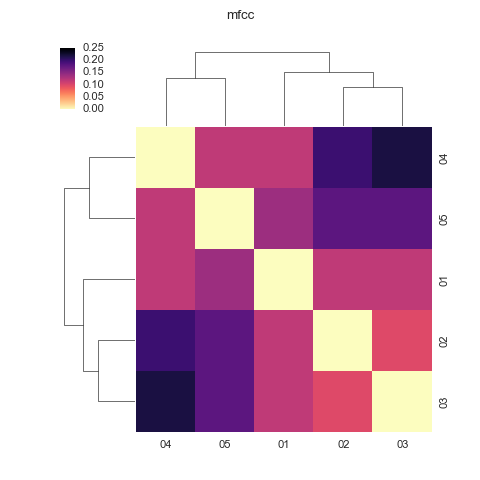

In [481]:
for feature in ['tempo', 'rhythm', 'chroma', 'mfcc']:
    linkage = hc.linkage(Kt[feature], method='average')
    sns.clustermap(Kt[feature], row_linkage=linkage, col_linkage=linkage, cmap='magma_r', figsize=(6,6), vmin=0, vmax=0.25)
    plt.suptitle(feature)
    

In [482]:
plt.close('all')

<IPython.core.display.Javascript object>


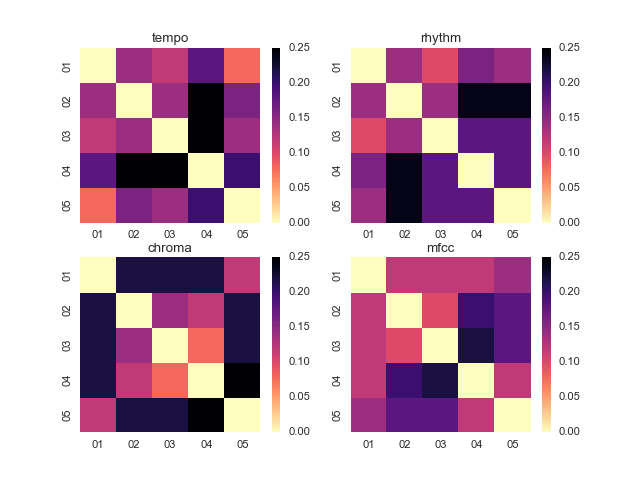

In [206]:
plt.figure()
ax = None
for i, feature in enumerate(['tempo', 'rhythm', 'chroma', 'mfcc'], 1):
    ax = plt.subplot(2,2,i, sharex=ax, sharey=ax)
    sns.heatmap(Kt[feature], cmap='magma_r', vmin=0, vmax=0.25)
    
    plt.title(feature)

In [523]:
Pd['chroma']

array([[ 1.  ,  0.15,  0.15,  0.15,  0.84],
       [ 0.15,  1.  ,  0.68,  0.84,  0.15],
       [ 0.15,  0.68,  1.  ,  1.  ,  0.15],
       [ 0.15,  0.84,  1.  ,  1.  ,  0.06],
       [ 0.84,  0.15,  0.15,  0.06,  1.  ]])

<IPython.core.display.Javascript object>


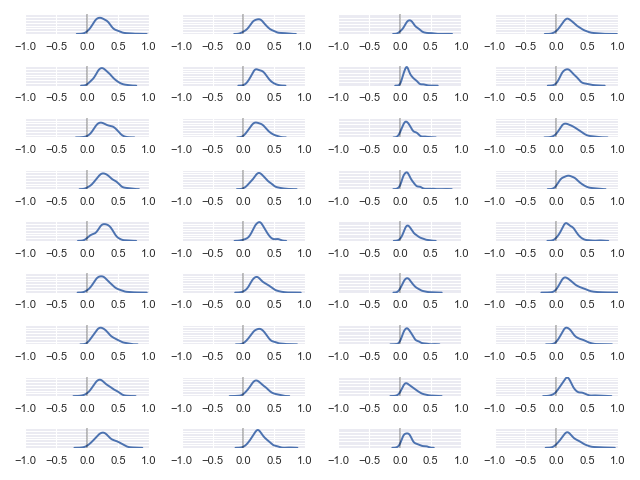

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [264]:
plt.figure()

i = 1

sharex = dict()
sharey = dict()

for an in sorted(anonymap.values()):
    for col in ['tempo', 'rhythm', 'chroma', 'mfcc']:
    
        _x = sharex.get(an, None)
        _y = sharey.get(col, None)
            
        ax_new = plt.subplot(len(anonymap), 4, i, sharey=_y, sharex=_y)
        #ax_new = plt.subplot(4, 5, i, sharey=_x, sharex=_y)
        
        sns.kdeplot(Fanon[Fanon.annotator == an][col], legend=False)
        plt.axvline(0, alpha=0.25, color='k')
        
        
        #if an not in sharex:
        #    ax_new.set_ylabel(an)
            #ax_new.set_title(an)
        
        #if col not in sharey:
        #    ax_new.set_ylabel(col)
            
        ax_new.set_yticklabels([])
        ax_new.set_xlim([-1, 1])
        
        if i > 10016:
            ax_new.set_xlabel(col)
            ax_new.xaxis.set_visible(True)
            
        else:
            #ax_new.xaxis.set_visible(False)
            pass
        
        i = i + 1
        
        sharex.setdefault(an, ax_new)
        sharey.setdefault(col, ax_new)
        
plt.tight_layout()


---

<IPython.core.display.Javascript object>


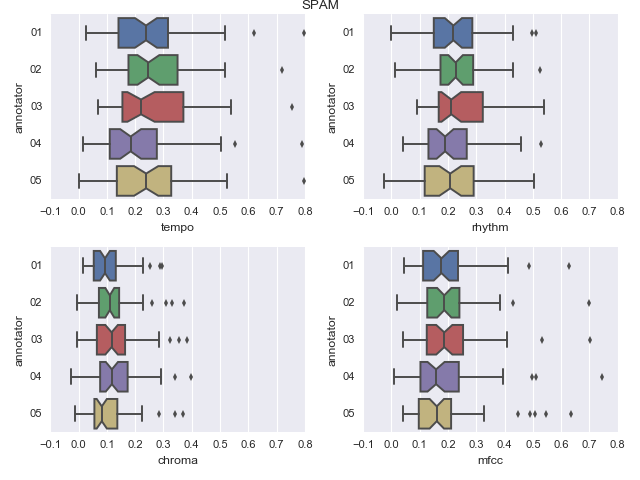

In [24]:
plt.figure()
ax = plt.subplot(2,2,1)
sns.boxplot(y='annotator', x='tempo', notch=True, data=Fanon, orient='h')

plt.subplot(2,2,2, sharex=ax)
sns.boxplot(y='annotator', x='rhythm', notch=True, data=Fanon, orient='h')

plt.subplot(2,2,3, sharex=ax)
sns.boxplot(y='annotator', x='chroma', notch=True, data=Fanon, orient='h')

plt.subplot(2,2,4, sharex=ax)
sns.boxplot(y='annotator', x='mfcc', notch=True, data=Fanon, orient='h')
plt.suptitle(SETNAME, y=1.0)
plt.tight_layout()

<IPython.core.display.Javascript object>


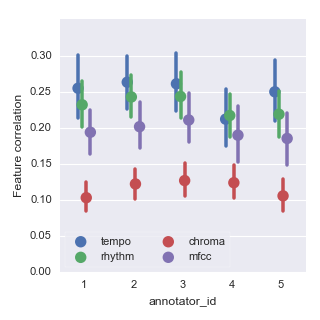

<IPython.core.display.Javascript object>


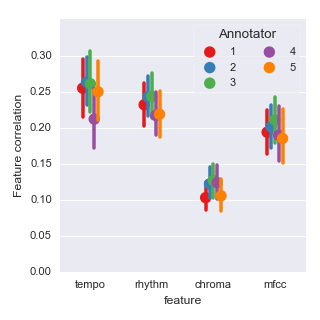

In [68]:

sns.factorplot(x='annotator_id', y='corr', hue='feature', data=Fmelt, n_boot=1000, kind='point',
               legend=False, dodge=0.25, alpha=0.5, join=False)
plt.ylim([0, 0.35])
plt.ylabel('Feature correlation')
plt.legend(loc='best', frameon=True, framealpha=0.8, ncol=2)
plt.savefig('../data/figures/{}_annotator_feature_corr.pdf'.format(SETNAME), pad_inches=0)


sns.factorplot(x='feature', y='corr', hue='annotator_id', data=Fmelt, n_boot=1000, kind='point',
               legend=False, dodge=0.25, alpha=0.5, join=False, palette='Set1')
plt.ylim([0, 0.35])
plt.ylabel('Feature correlation')
plt.legend(loc='best', frameon=True, framealpha=0.8, ncol=2, title='Annotator')
plt.savefig('../data/figures/{}_feature_annotator_corr.pdf'.format(SETNAME), pad_inches=0)

---
# Feature anova

In [26]:
import statsmodels as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [27]:
trackid = {t: i for i, t in enumerate(Fanon.track.unique())}
featureid = {t: i for i, t in enumerate(['tempo', 'rhythm', 'chroma', 'mfcc'])}

In [28]:
Fanon['track_id'] = Fanon.track.apply(lambda x: trackid[x])
Fanon['annotator_id'] = Fanon.annotator.apply(lambda x: int(x))

In [29]:
Fmelt = pd.melt(Fanon, id_vars=['annotator_id', 'track_id'],
                value_vars=['tempo', 'rhythm', 'chroma', 'mfcc'],
                value_name='corr', var_name='feature')

In [30]:
Fmelt['feature_id'] = Fmelt.feature.apply(lambda x: featureid[x])

In [31]:
formulae = dict()
for feature in ['tempo', 'rhythm', 'chroma', 'mfcc']:
    formulae[feature] = '{} ~ C(track_id) + C(annotator_id) + C(track_id):C(annotator_id)'.format(feature)
    #formulae[feature] = '{} ~ C(track_id) + C(annotator_id)'.format(feature)
    #formulae[feature] = '{} ~ C(track_id)'.format(feature)
    
    #formulae[feature] = '{} ~ C(annotator_id)'.format(feature)
    

In [32]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov
 
def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

In [499]:
model = dict()
aov = dict()
for feature in ['tempo', 'rhythm', 'chroma', 'mfcc']:
    model[feature] = ols(formulae[feature], Fanon).fit()
    aov[feature] = anova_lm(model[feature], robust='hc3', typ=1)
    eta_squared(aov[feature])
    omega_squared(aov[feature])
    print(feature)
    print(aov[feature])
    #print(aov[feature][['df', 'F', 'PR(>F)', 'mean_sq', 'eta_sq', 'omega_sq']])
    print('-' * 80)

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/stats/anova.py:132: RuntimeWarning: divide by zero encountered in double_scalars
  (model.ssr/model.df_resid))
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in double_scalars


tempo
                                df        sum_sq   mean_sq    F  PR(>F)  \
C(track_id)                   49.0  4.296553e+00  0.087685  0.0     NaN   
C(annotator_id)                4.0  8.710780e-02  0.021777  0.0     NaN   
C(track_id):C(annotator_id)  196.0  9.015529e-01  0.004600  0.0     NaN   
Residual                       0.0  1.227010e-28       inf  NaN     NaN   

                               eta_sq  omega_sq  
C(track_id)                  0.812938       NaN  
C(annotator_id)              0.016481       NaN  
C(track_id):C(annotator_id)  0.170580       NaN  
Residual                          NaN       NaN  
--------------------------------------------------------------------------------
rhythm
                                df        sum_sq   mean_sq    F  PR(>F)  \
C(track_id)                   49.0  2.397669e+00  0.048932  0.0     NaN   
C(annotator_id)                4.0  3.169381e-02  0.007923  0.0     NaN   
C(track_id):C(annotator_id)  196.0  6.415791e-01  0.003

In [526]:
model = ols('corr ~ C(feature_id) + C(annotator_id) + C(annotator_id):C(feature_id)', Fmelt).fit()

In [522]:
#model = ols('corr ~ C(feature_id) + C(track_id) + C(feature_id):C(track_id)', Fmelt).fit()

In [527]:
aov = anova_lm(model, robust='hc3', typ=3)
eta_squared(aov)
omega_squared(aov)
aov

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
Intercept,1.939399,1.0,140.195830,2.518825e-30,0.116346,0.115420
C(feature_id),1.044447,3.0,25.167094,1.088294e-15,0.062657,0.060117
C(annotator_id),0.056265,4.0,1.016830,3.975414e-01,0.003375,0.000056
C(annotator_id):C(feature_id),0.072348,12.0,0.435826,9.493818e-01,0.004340,-0.005614
Residual,13.556830,980.0,NaN,NaN,NaN,NaN


In [525]:
Fmelt.to_csv('../data/{}_annotator_track_feature.csv'.format(SETNAME), index=False)

---
# Delta

In [149]:
bp.show(bscat(Rf, 'delta_w', 'MULTI_L-Measure', plot_width=600, plot_height=600))

In [444]:
#Rf[Rf.TRACK == '410.jams'][['annotator 1', 'annotator 2', 'MULTI_L-Measure', 'delta_w']]
Rf[Rf.TRACK == '12.jams'][['annotator 1', 'annotator 2', 'MULTI_L-Measure', 'delta_w']]
#Rf[Rf.TRACK == '936.jams'][['annotator 1', 'annotator 2', 'MULTI_L-Measure', 'delta_w']]

,annotator 1,annotator 2,MULTI_L-Measure,delta_w
874,2,6,0.399123,0.088822
875,2,6,0.399123,0.088822


In [99]:
#Rf[Rf.TRACK == 'SALAMI_1072.jams'][['annotator 1', 'annotator 2', 'MULTI_L-Measure', 'delta_w']]
Rf[Rf.TRACK == 'SALAMI_20.jams'][['annotator 1', 'annotator 2', 'MULTI_L-Measure', 'delta_w']]
#Rf[Rf.TRACK == 'Isophonics_07_-_Maggie_Mae.jams'][['annotator 1', 'annotator 2', 'MULTI_L-Measure', 'delta_w']]

,annotator 1,annotator 2,MULTI_L-Measure,delta_w
600,John Turner,Eleni Vasilia Maltas,0.457950,0.325601
601,John Turner,Eleni Vasilia Maltas,0.457950,0.325601
602,John Turner,Colin Hua,0.491574,0.303936
603,John Turner,Colin Hua,0.491574,0.303936
604,Eleni Vasilia Maltas,Colin Hua,0.699183,0.080990
605,Eleni Vasilia Maltas,Colin Hua,0.699183,0.080990
606,John Turner,Evan S. Johnson,0.485962,0.210158
607,John Turner,Evan S. Johnson,0.485962,0.210158
608,Eleni Vasilia Maltas,Evan S. Johnson,0.613459,0.235330
609,Eleni Vasilia Maltas,Evan S. Johnson,0.613459,0.235330


<IPython.core.display.Javascript object>


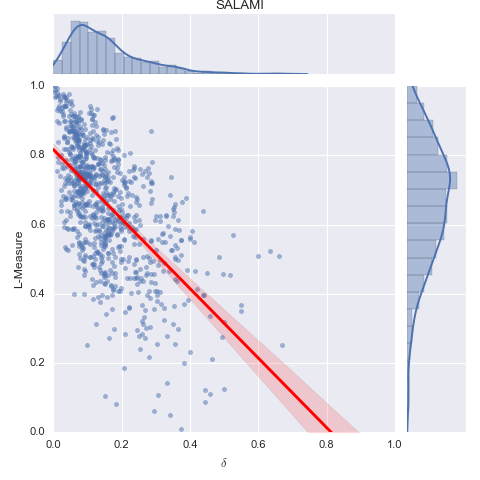

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [176]:
jg = sns.jointplot(Rf['delta_w'],
              Rf['MULTI_L-Measure'],
              kind='reg',
              ylim=[0, 1],
              xlim=[0, 1],
              line_kws=dict(color='r'),
              stat_func=None,
              scatter_kws=dict(alpha=0.5),
                   joint_kws=dict(robust=True)
             )
jg.ax_joint.set_xlabel(r'$\delta$')
jg.ax_joint.set_ylabel('L-Measure')
#jg.ax_joint.axis('tight')
jg.ax_joint.set_ylim([0, 1])
#jg.ax_joint.set_xlim([0, 1])#Rf['delta_w'].max()])
plt.suptitle(SETNAME, y=1.0)
plt.savefig('../data/figures/{}_label_delta_l_measure.pdf'.format(SETNAME), pad_inches=0)

<IPython.core.display.Javascript object>


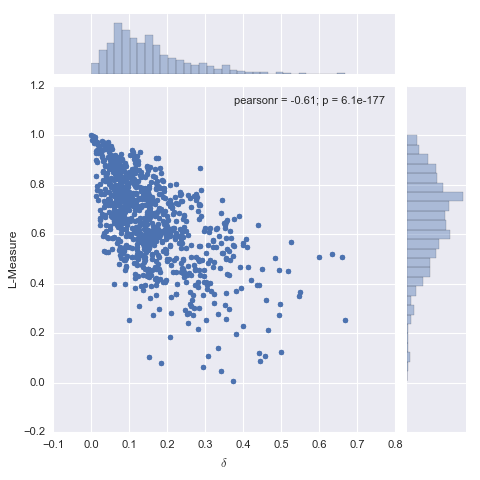

In [175]:
jg = sns.jointplot(Rf['delta_w'],
              Rf['MULTI_L-Measure'], kind='scatter')#, ylim=[0, 1], xlim=[0, 1])
jg.ax_joint.set_xlabel(r'$\delta$')
jg.ax_joint.set_ylabel('L-Measure')
#plt.savefig('../data/figures/{}_label_delta_l_measure.pdf'.format(SETNAME), pad_inches=0)

In [ ]:
Rf.keys()

<IPython.core.display.Javascript object>


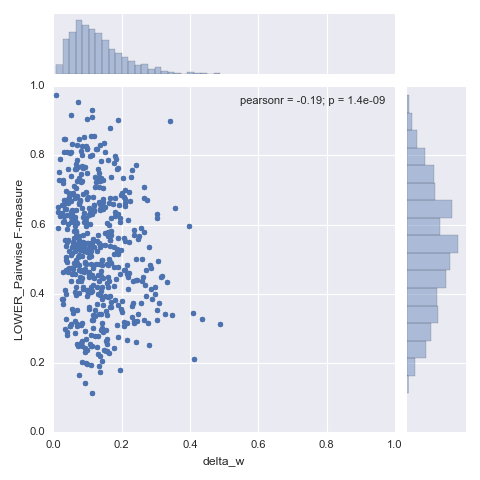

In [95]:
jg = sns.jointplot(Rf['delta_w'],
              Rf['LOWER_Pairwise F-measure'], kind='scatter', ylim=[0, 1], xlim=[0, 1])

<IPython.core.display.Javascript object>


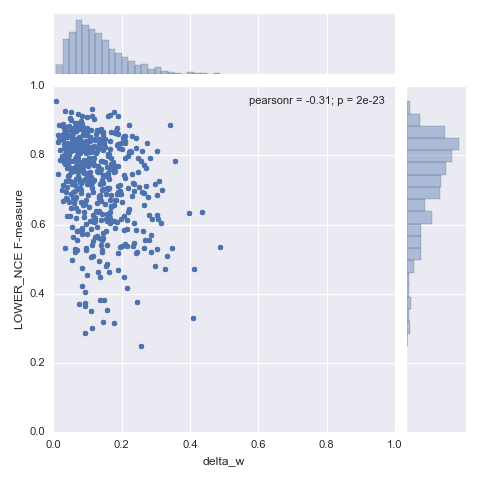

In [96]:
jg = sns.jointplot(Rf['delta_w'],
              Rf['LOWER_NCE F-measure'], kind='scatter', ylim=[0, 1], xlim=[0, 1])

<IPython.core.display.Javascript object>


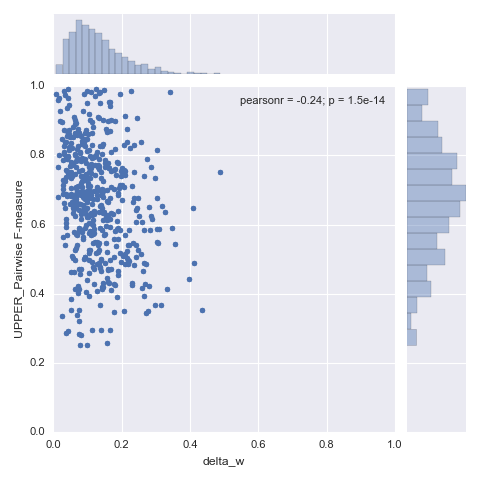

In [97]:
jg = sns.jointplot(Rf['delta_w'],
              Rf['UPPER_Pairwise F-measure'], kind='scatter', ylim=[0, 1], xlim=[0, 1])
#plt.savefig('../data/figures/{}_label_delta_l_measure.pdf'.format(SETNAME), pad_inches=0)

<IPython.core.display.Javascript object>


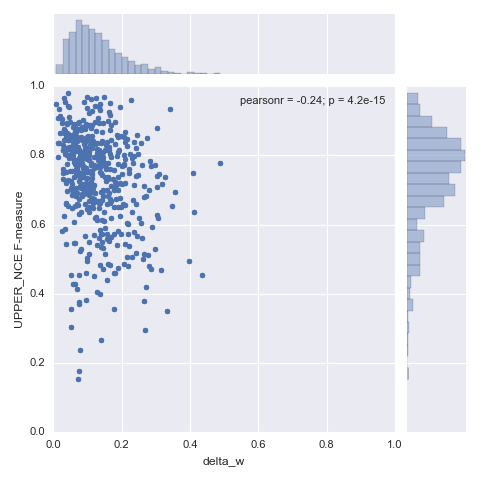

In [98]:
jg = sns.jointplot(Rf['delta_w'],
              Rf['UPPER_NCE F-measure'], kind='scatter', ylim=[0, 1], xlim=[0, 1])

----
# Algorithm results

In [143]:
if SALAMI:
    alg_results = pickle.load(open('../data/salami_algorithm_results.pickle', 'rb'))
else:
    alg_results = pickle.load(open('../data/spam_algorithm_results.pickle', 'rb'))

In [144]:
for k in range(len(alg_results)):
    for u1 in alg_results[k]:
        for u2 in dict(alg_results[k][u1]):
            pass
            #alg_results[k][u1][u2]['TRACK'] = k

results_tab = []
for track in range(len(alg_results)):
    for a1 in alg_results[track]:
        for a2 in alg_results[track][a1]:
            v = dict()
            v.update(alg_results[track][a1][a2])
            v['annotator 1'] = a1
            v['annotator 2'] = a2
            results_tab.append(v)
Ralg = pd.DataFrame.from_records(results_tab)

In [145]:
Rs = Ralg.sort_values('MULTI_L-Measure')

In [146]:
import scipy.stats

In [147]:
R_recall = pd.concat([R['MULTI_L-Recall'], R['MULTI_L-Precision']])

In [148]:
olda_prec = scipy.stats.ks_2samp(Ralg[Ralg['annotator 2'] == 'olda']['MULTI_L-Precision'], R_recall)[0]
lap_prec = scipy.stats.ks_2samp(Ralg[Ralg['annotator 2'] == 'scluster']['MULTI_L-Precision'], R_recall)[0]
olda_rec = scipy.stats.ks_2samp(Ralg[Ralg['annotator 2'] == 'olda']['MULTI_L-Recall'], R_recall)[0]
lap_rec = scipy.stats.ks_2samp(Ralg[Ralg['annotator 2'] == 'scluster']['MULTI_L-Recall'], R_recall)[0]
olda_f = scipy.stats.ks_2samp(Ralg[Ralg['annotator 2'] == 'olda']['MULTI_L-Measure'], R_recall)[0]
lap_f = scipy.stats.ks_2samp(Ralg[Ralg['annotator 2'] == 'scluster']['MULTI_L-Measure'], R_recall)[0]

<IPython.core.display.Javascript object>


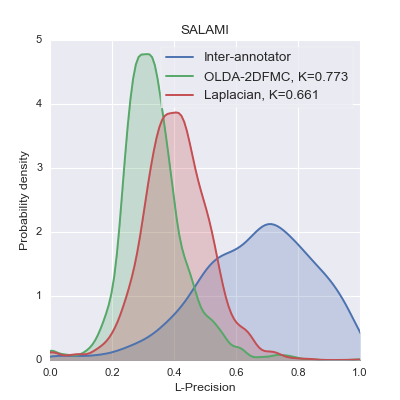

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [149]:
plt.figure(figsize=(5,5))
#sns.kdeplot(R['MULTI_L-Measure'].dropna(), label='Inter-annotator', shade=True)
sns.kdeplot(R_recall, label='Inter-annotator', shade=True)
sns.kdeplot(Ralg[Ralg['annotator 2'] == 'olda']['MULTI_L-Precision'], label='OLDA-2DFMC, K={:.3f}'.format(olda_prec), shade=True)
sns.kdeplot(Ralg[Ralg['annotator 2'] == 'scluster']['MULTI_L-Precision'], label='Laplacian, K={:.3f}'.format(lap_prec), shade=True)


plt.xlabel('L-Precision')
plt.ylabel('Probability density')
plt.legend(frameon=True, framealpha=0.8, fontsize=12)
plt.title(SETNAME)
plt.xlim([0, 1])
plt.savefig('../data/figures/{}_algorithms_precision.pdf'.format(SETNAME), pad_inches=0)

<IPython.core.display.Javascript object>


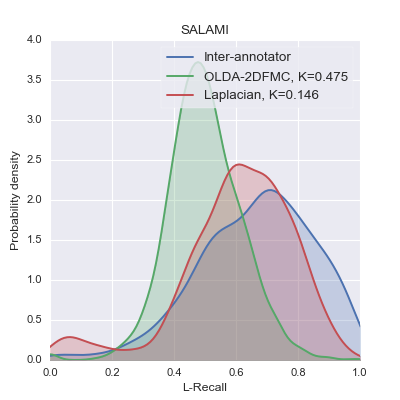

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [150]:
plt.figure(figsize=(5,5))
#sns.kdeplot(R['MULTI_L-Measure'].dropna(), label='Inter-annotator', shade=True)
sns.kdeplot(R_recall, label='Inter-annotator', shade=True)
sns.kdeplot(Ralg[Ralg['annotator 2'] == 'olda']['MULTI_L-Recall'], label='OLDA-2DFMC, K={:.3f}'.format(olda_rec), shade=True)
sns.kdeplot(Ralg[Ralg['annotator 2'] == 'scluster']['MULTI_L-Recall'], label='Laplacian, K={:.3f}'.format(lap_rec), shade=True)


plt.xlabel('L-Recall')
plt.ylabel('Probability density')
plt.legend(frameon=True, framealpha=0.8, fontsize=12)
plt.title(SETNAME)
plt.xlim([0, 1])
plt.savefig('../data/figures/{}_algorithms_recall.pdf'.format(SETNAME), pad_inches=0)

In [151]:
Ralg[Ralg['annotator 2'] == 'olda']['MULTI_L-Recall'].mean()

0.4992926444446038

In [152]:
Ralg[Ralg['annotator 2'] == 'scluster']['MULTI_L-Recall'].mean()

0.6058359916095705

<IPython.core.display.Javascript object>


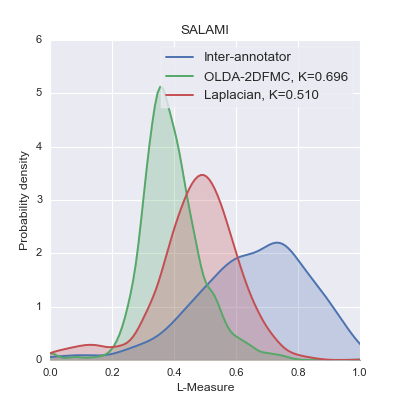

/home/bmcfee/miniconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [153]:
plt.figure(figsize=(5,5))
sns.kdeplot(R['MULTI_L-Measure'].dropna(), label='Inter-annotator', shade=True)
#sns.kdeplot(R_recall, label='Inter-annotator', shade=True)
sns.kdeplot(Ralg[Ralg['annotator 2'] == 'olda']['MULTI_L-Measure'], label='OLDA-2DFMC, K={:.3f}'.format(olda_f), shade=True)
sns.kdeplot(Ralg[Ralg['annotator 2'] == 'scluster']['MULTI_L-Measure'], label='Laplacian, K={:.3f}'.format(lap_f), shade=True)


plt.xlabel('L-Measure')
plt.ylabel('Probability density')
plt.legend(frameon=True, framealpha=0.8, fontsize=12)
plt.title(SETNAME)
plt.xlim([0, 1])
plt.savefig('../data/figures/{}_algorithms.pdf'.format(SETNAME), pad_inches=0)

---
# Only makes sense for SPAM below

# Idea

- On SPAM, group by track, and make a swarm plot of pairwise agreement scores using different metrics
- If things work out well, we should see less spread using L-measures

In [ ]:
import jams.display

In [ ]:
#filename = 'Cerulean_Boston_Symphony_Orchestra_&_Charles_Munch-Sympho'
filename = 'SALAMI_114' # lowest average L-measure
filename = 'SALAMI_278' # highest average L-measure
filename = 'SALAMI_108' # biggest spread

In [ ]:
jam = jams.load('/home/bmcfee/git/msaf-data/SPAM/references/{}.jams'.format(filename), validate=False)

In [ ]:
multis = jam.search(namespace='multi_segment')

In [ ]:
filename

In [ ]:
jams.display.display_multi(jam.annotations['multi'], meta=False, fig_kw=dict(figsize=(8,12)))
plt.tight_layout()

In [ ]:
jams.display.display_multi(multis.search(name=lambda x: x in [name1, name2]), meta=False)
plt.tight_layout()

In [ ]:
#filename = track_variance['MULTI_L-Measure'].argmin()
#filename = track_variance['MULTI_L-Measure'].argmax()

#filename = track_variance['UPPER_NCE F-measure'].argmax()
#filename = track_variance['UPPER_NCE F-measure'].argmin()

#filename = track_variance['LOWER_NCE F-measure'].argmax()
#filename = track_variance['LOWER_NCE F-measure'].argmin()

#filename = track_variance['UPPER_Pairwise F-measure'].argmax()
#filename = track_variance['UPPER_Pairwise F-measure'].argmin()

#filename = track_variance['LOWER_Pairwise F-measure'].argmax()
#filename = track_variance['LOWER_Pairwise F-measure'].argmin()

In [ ]:
filename = track_mean['MULTI_L-Measure'].argmax()
#filename = track_mean['MULTI_L-Measure'].argmin()

#filename = track_mean['UPPER_NCE F-measure'].argmax()
#filename = track_mean['UPPER_NCE F-measure'].argmin()

#filename = track_mean['LOWER_NCE F-measure'].argmax()
#filename = track_mean['LOWER_NCE F-measure'].argmin()

#filename = track_mean['UPPER_Pairwise F-measure'].argmax()
#filename = track_mean['UPPER_Pairwise F-measure'].argmin()

#filename = track_mean['LOWER_Pairwise F-measure'].argmax()
#filename = track_mean['LOWER_Pairwise F-measure'].argmin()

In [ ]:
track_mean.loc[filename]

In [ ]:
filename

In [ ]:
jam = jams.load(os.path.join('/home/bmcfee/git/msaf-data/SPAM/references/', filename))

In [ ]:
%matplotlib nbagg

In [ ]:
fig, _ = jams.display.display_multi(jam.search(namespace='.*upper'), meta=False)
fig.suptitle(filename)
fig.tight_layout()

In [ ]:
fig, _ = jams.display.display_multi(jam.search(namespace='.*lower'), meta=False)
fig.suptitle(filename)
fig.tight_layout()

In [ ]:
fig, _ = jams.display.display_multi(jam.search(namespace='multi_segment'), meta=False)
fig.suptitle(filename)
fig.tight_layout()

---

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1,3,1)
sns.heatmap(R.iloc[0]['MULTI_T-Measure reduced'], square=True, cmap='plasma', vmin=0.0, vmax=1.)
plt.title('T-Measure (reduced)')
plt.subplot(1,3,2)
sns.heatmap(R.iloc[0]['MULTI_T-Measure full'], square=True, cmap='plasma', vmin=0.0, vmax=1.)
plt.title('T-Measure (full)')
plt.subplot(1,3,3)
sns.heatmap(R.iloc[0]['MULTI_L-Measure'], square=True, cmap='plasma', vmin=0.0, vmax=1.)
plt.title('L-Measure')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10, 3))
plt.subplot(1,3,1)
sns.heatmap(R.iloc[0]['LOWER_NCE F-measure'], square=True, cmap='plasma', vmin=0.5, vmax=1.)
plt.title('NCE (Lower)')
plt.subplot(1,3,2)
sns.heatmap(R.iloc[0]['UPPER_NCE F-measure'], square=True, cmap='plasma', vmin=0.5, vmax=1.)
plt.title('NCE (Upper)')
plt.subplot(1,3,3)
sns.heatmap(R.iloc[0]['MULTI_L-Measure'], square=True, cmap='plasma', vmin=0.5, vmax=1.)
plt.title('L-Measure')
plt.tight_layout()

In [ ]:
sns.heatmap(R.mean(axis=0)['MULTI_L-Measure'], square=True)

In [ ]:
sns.heatmap(R.mean(axis=0)['MULTI_T-Measure reduced'], square=True)

In [ ]:
sns.heatmap(R.mean(axis=0)['UPPER_NCE F-measure'])